In [1]:
import glob
import os
import json
import pickle as pkl
import yaml

import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import pyarrow.parquet as pq
from sklearn.metrics import auc, roc_curve
from scipy.special import softmax

import hist as hist2
import matplotlib.pyplot as plt
import mplhep as hep

plt.style.use(hep.style.CMS)

import matplotlib.pyplot as plt
import mplhep as hep
from hist.intervals import clopper_pearson_interval
def get_yerr(num,den):
    return abs(clopper_pearson_interval(num.view(), den.view()) - num.view()/den.view())

plt.rcParams.update({"font.size": 20})

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
outdir = "/Users/fmokhtar/Desktop/AN_2024/"

In [4]:
! ls ../eos/

July12_triggerSF_2017           June25_hww_2016
July18_hww_2016                 June25_hww_2016APV
July18_hww_2016APV              June25_hww_2017
July18_hww_2017                 June25_hww_2018
July18_hww_2018                 May23_LP_2017
July18_hww_uselooselep_2016     May27_fakes_cutbased_2017
July18_hww_uselooselep_2016APV  May27_fakes_mva_2017
July18_hww_uselooselep_2017     May28_electronmva_nometcut_2017
July18_hww_uselooselep_2018     May30_2017
July1_eleisoSF_2017             May31_fakes_2016
June11_LP_2016                  May31_fakes_2016APV
June11_LP_2016APV               May31_fakes_2017
June11_LP_2017                  May31_fakes_2018
June11_LP_2018                  May31_hww_uselooselep_2016
June1_LPvalidation_2017         May31_hww_uselooselep_2016APV
June1_LPvalidation_2018         May31_hww_uselooselep_2017
June21_zll_2016                 May31_hww_uselooselep_2018
June21_zll_2016APV              model.onnx
June21_zll_2017                 model_v35_12_14.onnx
June21_

In [5]:
def get_sum_sumgenweight(pkl_files, year, sample):
    sum_sumgenweight = 0
    for ifile in pkl_files:
        # load and sum the sumgenweight of each
        with open(ifile, "rb") as f:
            metadata = pkl.load(f)
        sum_sumgenweight = sum_sumgenweight + metadata[year][sample]["sumgenweight"]
    return sum_sumgenweight


def get_xsecweight(pkl_files, year, sample, is_data, luminosity):
    if not is_data:
        # find xsection
        f = open("../fileset/xsec_pfnano.json")
        xsec = json.load(f)
        f.close()
        try:
            xsec = eval(str((xsec[sample])))
        except ValueError:
            print(f"sample {sample} doesn't have xsecs defined in xsec_pfnano.json so will skip it")
            return None

        # get overall weighting of events.. each event has a genweight...
        # sumgenweight sums over events in a chunk... sum_sumgenweight sums over chunks
        xsec_weight = (xsec * luminosity) / get_sum_sumgenweight(pkl_files, year, sample)
    else:
        xsec_weight = 1
    return xsec_weight

In [6]:
ch = "ele"
year = "2017"

# get lumi
with open("../fileset/luminosity.json") as f:
    luminosity = json.load(f)[ch][year]

In [7]:
ch = "ele"
year = "2017"

### key=label, value=sample
samples_dict = {
    "Data": [
        "SingleMuon_Run2017B",
        "SingleMuon_Run2017C",
        "SingleMuon_Run2017D",
        "SingleMuon_Run2017E",
        "SingleMuon_Run2017F",
    ],
#     "TTbar": [
#         "TTTo2L2Nu",
#         "TTToHadronic",
#         "TTToSemiLeptonic",
#     ],
    "TTTo2L2Nu": [
        "TTTo2L2Nu",
    ],
    "TTToHadronic": [
        "TTToHadronic",
    ],
    "TTToSemiLeptonic": [
        "TTToSemiLeptonic",
    ],    
}


hists = hist2.Hist(
    hist2.axis.StrCategory([], name='samples', growth=True),
    hist2.axis.Variable(np.linspace(30, 430, 21), name='leppt', label=r'Lepton $p_T$ [GeV]', overflow=False),
)


for sample_label in samples_dict:
    
    print(f"Combining the following samples under {sample_label}")
    
    if sample_label == "Data":
        isData = True
    else:
        isData = False    
    
    for sample in samples_dict[sample_label]:
        print(sample)
        
        pkl_files = glob.glob(f"../eos/July12_triggerSF_2017/{sample}/outfiles/*.pkl")
        xsecweight = get_xsecweight(pkl_files, year, sample, isData, luminosity)
        
        # loop over all files of that sample
        X = []
        weights = []
        for i, file in enumerate(pkl_files):
            with open(file, "rb") as f:
                out = pkl.load(f)["2017"][sample]["skimmed_events"]["ele"]
        
            X += list(out["vars"]["lep_pt"])
            if not isData:           
                weights += list(out["weights"]["weight_genweight"])

        X = np.array(X)
        
        if isData:
            hists.fill(
                samples=sample_label,        
                leppt=X,
            )
            
        else:
            weights = np.array(weights)             
            weights *= xsecweight     

            hists.fill(
                samples=sample_label,        
                leppt=X,
                weight=weights,
            )
    print("-------------------------------------")

Combining the following samples under Data
SingleMuon_Run2017B
SingleMuon_Run2017C
SingleMuon_Run2017D
SingleMuon_Run2017E
SingleMuon_Run2017F
-------------------------------------
Combining the following samples under TTTo2L2Nu
TTTo2L2Nu
-------------------------------------
Combining the following samples under TTToHadronic
TTToHadronic
-------------------------------------
Combining the following samples under TTToSemiLeptonic
TTToSemiLeptonic
-------------------------------------


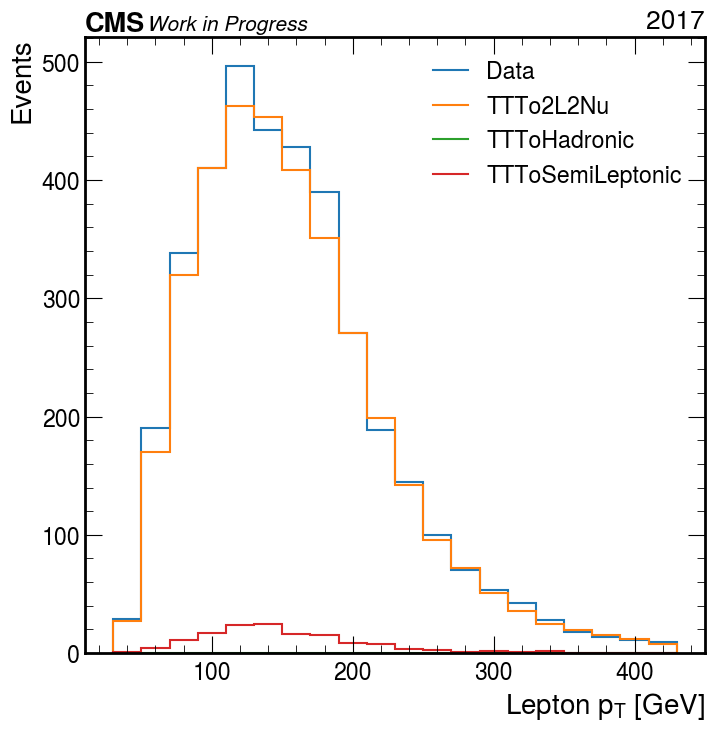

In [8]:
fig, ax = plt.subplots(figsize=(8,8))

for sample in hists.axes["samples"]:
    hists[{"samples": sample}].project("leppt").plot1d(label=sample)
    
# plt.yscale("log")
plt.legend()
plt.ylim(0)
plt.ylabel("Events")
hep.cms.lumitext(
    "2017", ax=ax, fontsize=20
)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)

plt.savefig(f"{outdir}/{ch}_1d_leppt.pdf")

# Electron trigger scale factors

In [9]:
! ls ../eos/July12_triggerSF_2017/

SingleMuon_Run2017B SingleMuon_Run2017D SingleMuon_Run2017F TTToHadronic
SingleMuon_Run2017C SingleMuon_Run2017E TTTo2L2Nu           TTToSemiLeptonic


In [95]:
var_dict, trg_dict, weight_dict = {}, {}, {}

with open("../eos/July12_triggerSF_2017/SingleMuon_Run2017B/outfiles/0-20.pkl", "rb") as f:
    out = pkl.load(f)["2017"]["SingleMuon_Run2017B"]["skimmed_events"]["ele"]

var_dict["Data"] = out["vars"].keys()    
trg_dict["Data"] = out["triggers"].keys()
weight_dict["Data"] = out["weights"].keys()

with open("../eos/July12_triggerSF_2017/TTTo2L2Nu/outfiles/0-10.pkl", "rb") as f:
    out = pkl.load(f)["2017"]["TTTo2L2Nu"]["skimmed_events"]["ele"]

var_dict["Simulation"] = out["vars"].keys()    
trg_dict["Simulation"] = out["triggers"].keys()
weight_dict["Simulation"] = out["weights"].keys()

In [96]:
ch = "ele"

hists = hist2.Hist(
    hist2.axis.StrCategory([], name='samples', growth=True),
    hist2.axis.StrCategory([], name='trigger', growth=True),    
    hist2.axis.Regular(10, -2.5, 2.5, name='lepeta', label=r'Lepton $\eta$'),
    hist2.axis.Variable(np.linspace(30, 430, 21), name='leppt', label=r'Lepton $p_T$ [GeV]', overflow=False),
)

### key=label, value=sample
samples_dict = {
    "Simulation": [
        "TTTo2L2Nu",
        "TTToHadronic",
        "TTToSemiLeptonic",
    ],       
    "Data": [
        "SingleMuon_Run2017B",
        "SingleMuon_Run2017C",
        "SingleMuon_Run2017D",
        "SingleMuon_Run2017E",
        "SingleMuon_Run2017F",
    ],    
}


legend_lab = {
    "120": r"$p_T$ < 120 GeV",
    "200-": r"120<$p_T$ < 200 GeV",
    "200+": r"$p_T$ > 200 GeV",    
}

for sample_label in samples_dict:
    
    Xs, trgs = {}, {}
    for key in var_dict[sample_label]:
        Xs[key] = []
    for key in trg_dict[sample_label]:
        trgs[key] = []
    
    print(f"Combining the following samples under {sample_label}")
    
    for sample in samples_dict[sample_label]:

        print(sample)
        
        for i, file in enumerate(glob.glob(f"../eos/July12_triggerSF_2017/{sample}/outfiles/*")):
            with open(file, "rb") as f:
                out = pkl.load(f)["2017"][sample]["skimmed_events"]["ele"]

            for key in Xs:
                Xs[key] += list(out["vars"][key])
            for key in trgs:
                trgs[key] += list(out["triggers"][key])

    for key in Xs:
        Xs[key] = np.array(Xs[key])
    for key in trgs:
        trgs[key] = np.array(trgs[key])

    ptcut = "200+"
    
    if ptcut == "120":
        msk_leppt = (Xs["lep_pt"] < 120)
    elif ptcut == "200-":
        msk_leppt = (Xs["lep_pt"] > 120) & (Xs["lep_pt"] < 200)
    elif ptcut == "200+":
        msk_leppt = (Xs["lep_pt"] < 200)

    leg = legend_lab[ptcut]
    
    # save events before trigger        
    hists.fill(
        samples=sample_label,        
        trigger="before_triggers",
        leppt=Xs["lep_pt"][msk_leppt],
        lepeta=Xs["lep_eta"][msk_leppt],
    )

    ########## build the OR of all triggers
    msk_trg = np.zeros(len(Xs["lep_pt"][msk_leppt]), dtype="bool")

    for trig in trgs:
        msk_trg = msk_trg | trgs[trig][msk_leppt]

    # save an events before trigger        
    hists.fill(
        samples=sample_label,
        trigger="or_of_triggers",        
        leppt=Xs["lep_pt"][msk_leppt][msk_trg],
        lepeta=Xs["lep_eta"][msk_leppt][msk_trg],
    )
    print("-------------------------------------")    

Combining the following samples under Simulation
TTTo2L2Nu
TTToHadronic
TTToSemiLeptonic
-------------------------------------
Combining the following samples under Data
SingleMuon_Run2017B
SingleMuon_Run2017C
SingleMuon_Run2017D
SingleMuon_Run2017E
SingleMuon_Run2017F
-------------------------------------


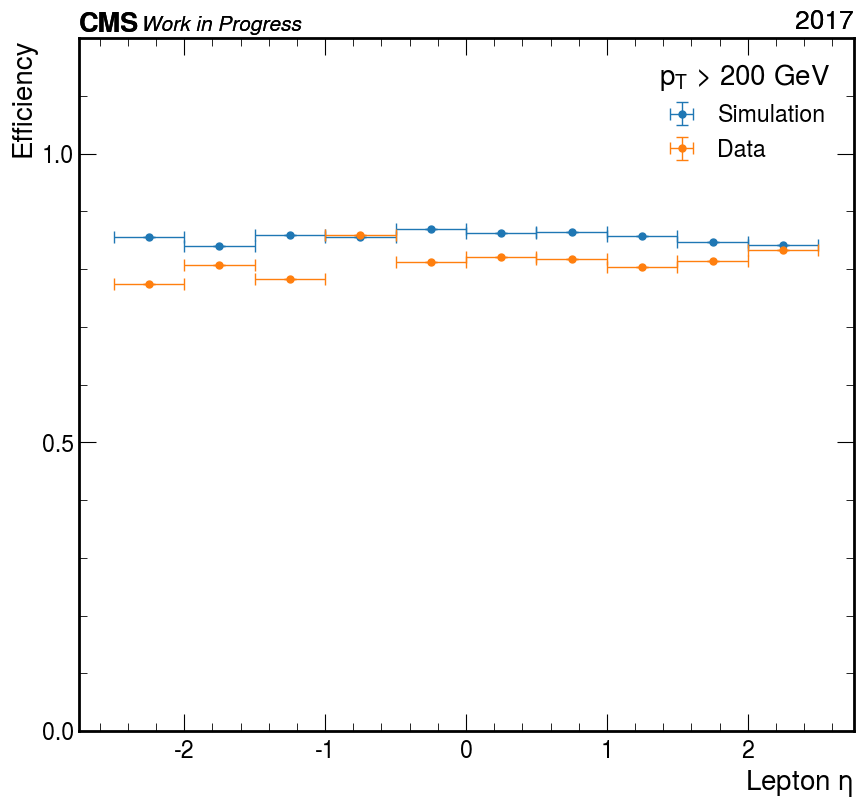

In [100]:
plt.rcParams.update({"font.size": 20})

fig, ax = plt.subplots(figsize=(10,9))

bin_size = (hists.axes["lepeta"].edges[1] - hists.axes["lepeta"].edges[0])


for sample_label in [
    "Simulation",
    "Data",
]:

    den = hists[{"samples": sample_label, "trigger": "before_triggers", 'leppt': sum}]
    num = hists[{"samples": sample_label, "trigger": "or_of_triggers", 'leppt': sum}]
    
    eff = num/den
    hep.histplot(eff,
                 ax = ax,
                 label=sample_label,
                 histtype='errorbar', 
#                  yerr=get_yerr(num, den),
                 yerr=0,                 
                 xerr=bin_size/2,
                 capsize=4, 
                 elinewidth=1,
                 flow=None,             
    )

    ax.set_ylim(0,1.2)
    ax.set_yticks([0, 0.5, 1])
    ax.legend(title=leg)
    ax.set_ylabel("Efficiency")
    hep.cms.lumitext(
        "2017", ax=ax, fontsize=20
    )
    hep.cms.text("Work in Progress", ax=ax, fontsize=15)

    plt.savefig(f"{outdir}/{ch}_trgeff_1d_leppt_{leg}.pdf")

In [84]:
def unc_fraction(num, den, unc_num=None, unc_den=None):
    
    """if either unc_num/unc_den are None, will use poissonian."""
    
    sf = num/den
    
    if unc_num is None:
        unc_num = np.sqrt(num)

    if unc_den is None:
        unc_den = np.sqrt(den)
        
    sf_unc = sf * np.sqrt( (unc_num/num)**2 + (unc_den/den)**2 )    
    
    return sf_unc

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


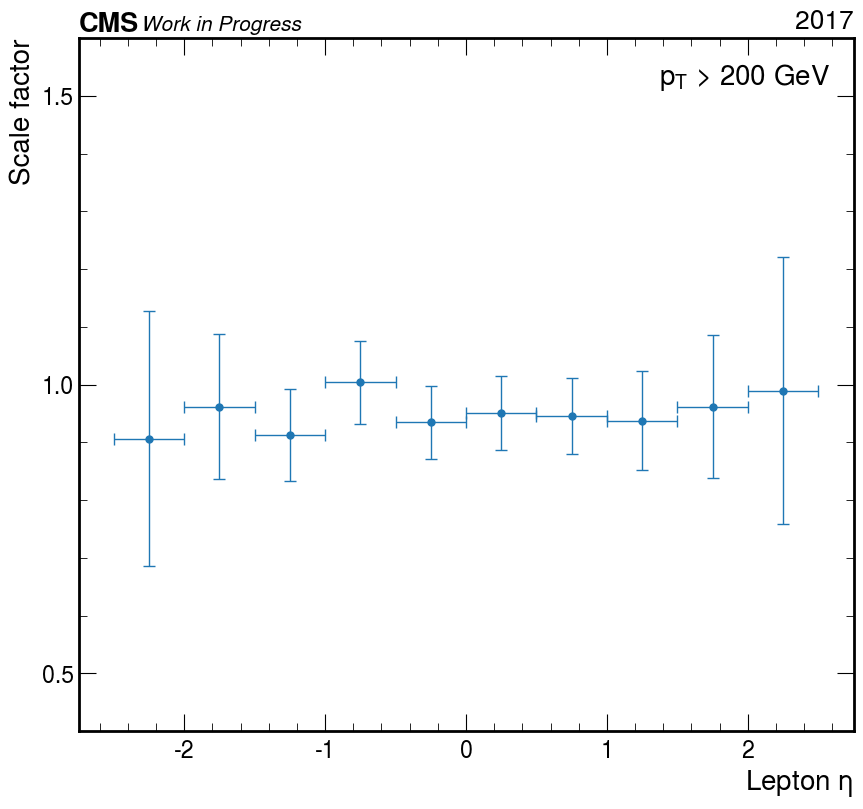

In [101]:
plt.rcParams.update({"font.size": 20})

fig, ax = plt.subplots(figsize=(10,9))

bin_size = (hists.axes["lepeta"].edges[1] - hists.axes["lepeta"].edges[0])

den = hists[{"samples": "Simulation", "trigger": "before_triggers", 'leppt': sum}]
num = hists[{"samples": "Simulation", "trigger": "or_of_triggers", 'leppt': sum}]
eff_MC = (num / den)
unc_MC = unc_fraction(num.values(), den.values())

den = hists[{"samples": "Data", "trigger": "before_triggers", 'leppt': sum}]
num = hists[{"samples": "Data", "trigger": "or_of_triggers", 'leppt': sum}]
eff_Data = num / den
unc_Data = unc_fraction(num.values(), den.values())

sf = eff_Data/eff_MC
sf_unc = unc_fraction(eff_Data.values(), eff_MC.values(), unc_num=unc_Data, unc_den=unc_MC)

hep.histplot(sf,
             ax = ax,
             histtype='errorbar', 
             yerr=sf_unc,
             xerr=bin_size/2,
             capsize=4, 
             elinewidth=1,
             flow=None,             
)

ax.set_ylim(0.4,1.6)
ax.set_yticks([0.5, 1, 1.5])
ax.legend(title=leg)
ax.set_ylabel("Scale factor")
hep.cms.lumitext(
    "2017", ax=ax, fontsize=20
)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)

plt.savefig(f"{outdir}/{ch}_sf_{leg}.pdf")